In [14]:
# Imports
import numpy as np
from pydub import AudioSegment
import noisereduce as nr
import soundfile as sf
from pydub.playback import play

import matplotlib.pyplot as plt
from scipy.signal import spectrogram

import ipywidgets as widgets
from IPython.display import display

In [5]:
# Load the audio file
audio_file = "../Keystrokes_1.wav"  # Replace with your audio file path
data, sample_rate = sf.read(audio_file)

In [6]:
# Reduce noise
reduced_noise = nr.reduce_noise(y=data, sr=sample_rate, prop_decrease=.75)

# Save the cleaned audio to a new file
output_file = "../cleaned_output.wav"
sf.write(output_file, reduced_noise, sample_rate)

audio = AudioSegment.from_wav(output_file)

In [29]:
# Process audio into segments

# Create a list to hold the keystroke segments
keystroke_segments = []
keystroke_times = []
threshold = 20

# Define a function to calculate RMS energy
def calculate_rms(segment):
    return np.sqrt(np.mean(np.square(segment.get_array_of_samples())))

# Analyze the audio in small chunks
chunk_size = 200  # Size of each chunk in milliseconds
for start in range(0, len(audio), chunk_size):
    segment = audio[start:start + chunk_size]
    if calculate_rms(segment) > threshold:  # Define a suitable threshold
        keystroke_segments.append(segment)
        keystroke_times.append((start, start + chunk_size))


# Now you can work with the keystroke segments
# For example, you can export each segment to a file
#for i, segment in enumerate(keystroke_segments):
    #print(i)
    #play(segment)

print(f"Extracted {len(keystroke_segments)} keystroke segments.")

Extracted 277 keystroke segments.


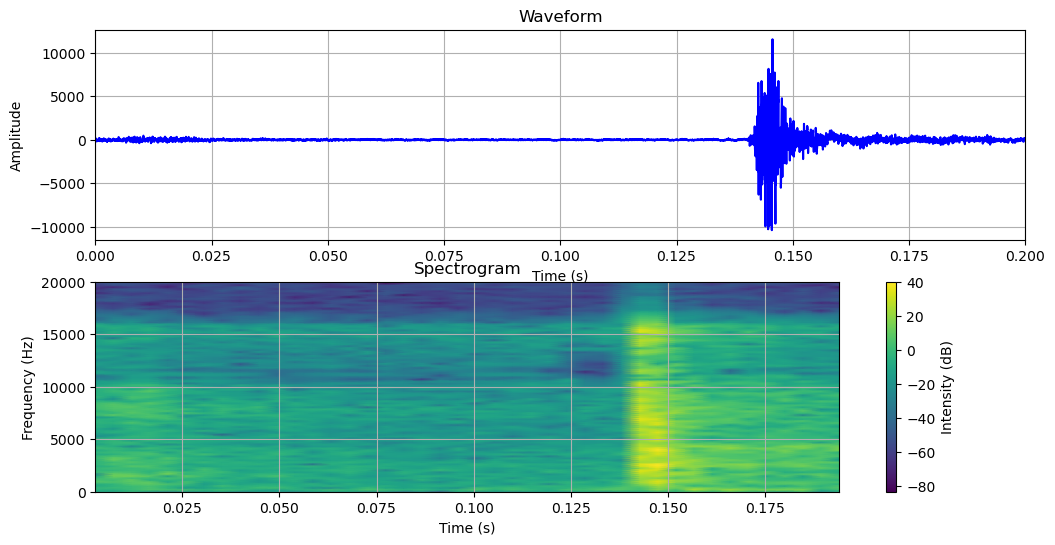

In [33]:
# Display audio segment
audio_segment = keystroke_segments[60]

def display_audio(audio, times=None):
    samples = np.array(audio.get_array_of_samples())
    # Handles stereo
    if audio.channels == 2:
        samples = samples.reshape((-1, 2))
    
    # Create a time array for the x-axis
    time = np.linspace(0, len(samples) / audio.frame_rate, num=len(samples))

    # Plotting the waveform
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(time, samples, color='blue')
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.xlim(0, time[-1])
    plt.grid()

    if times is not None:
        for start, end in times:
            plt.axvspan(start/1000, end/1000, color='red', alpha=0.5)  # Adjust color and transparency
    

    # Create a spectrogram
    frequencies, times, Sxx = spectrogram(samples[:], fs=audio.frame_rate)  # Use one channel for spectrogram

    # Plotting the spectrogram
    plt.subplot(2, 1, 2)
    plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
    plt.title('Spectrogram')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.colorbar(label='Intensity (dB)')
    plt.ylim(0, 20000)  # Limit frequency range to 20 kHz for better visibility
    plt.grid()

    plt.show()


display_audio(audio_segment)
play(audio_segment)

C:\Users\nmcph\AppData\Local\Temp\ipykernel_18424\4153018291.py:33: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')


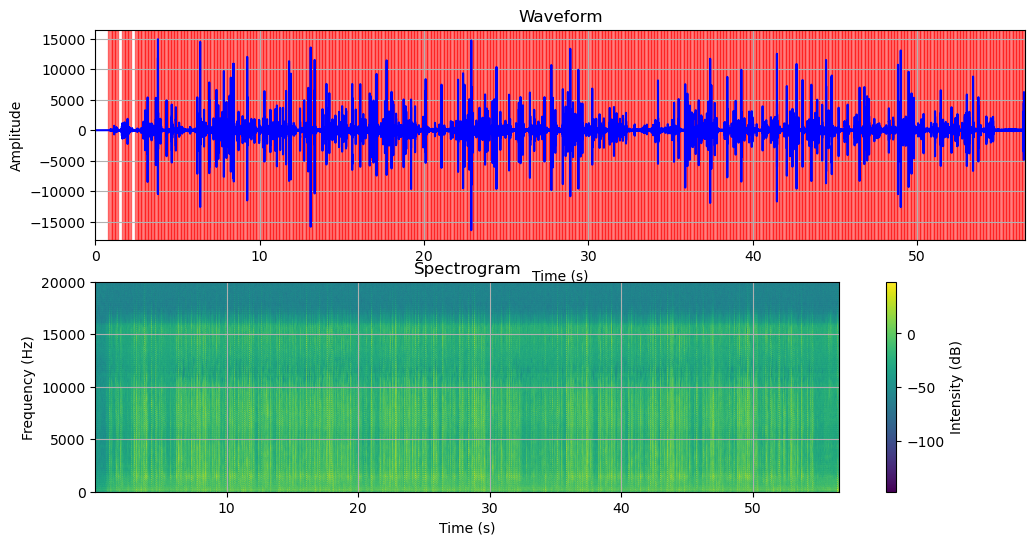

In [34]:
display_audio(audio, keystroke_times)

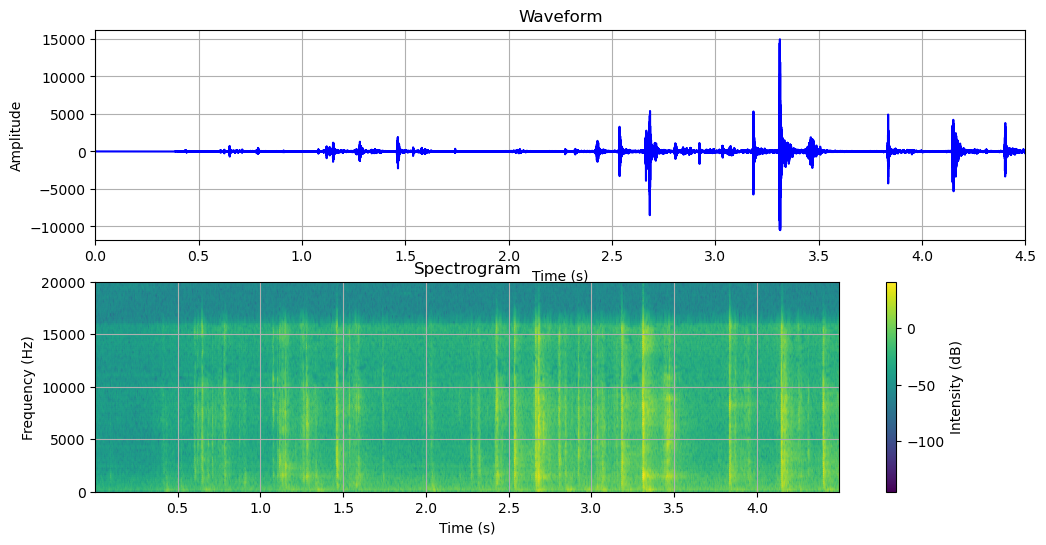

In [28]:
audio_segment = audio[500:5000]
display_audio(audio_segment)
play(audio_segment)